### Данный проект является учебным, направлен на изучение языка python, анализа данных и не несет в себе инвестиционных рекомендаций.

In [479]:
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10)})
import investpy
import pylab 
import scipy.stats as stats

In [480]:
# Указываем вводные данные

today = date.today().strftime("%d/%m/%Y")
# ==========================================================================================
stock = 'CLF' # указываем тикер акции
country = 'United States'
date_from = '01/01/2015'   # необходимо ввести дату, с которой собираем данные о котировках
date_to = today    # дата, по которую собираем данные, по умолчанию сегодняшний день
# =========================================================================================
# выбираем дату с которой строим графики, формат МЕСЯЦ/день/год
date_plot = '01/01/2021'

# выбираем дату для анализа и оценки эффективности стратегии (дату, с которой мы потенциально могли использовать стратегию)

strategy_date_from = date_plot # по умолчанию дата такая же, как для построения графиков

In [481]:
# Загружаем исторические данные, содержащие дневные ценовые диапазоны акций за указанный период
df = investpy.get_stock_historical_data(stock = stock,
                                        country = country,
                                        from_date = date_from,
                                        to_date = today)

In [482]:
# stocks_df = df.reset_index()
stocks_df = df

Text(0, 0.5, 'Цена в $')

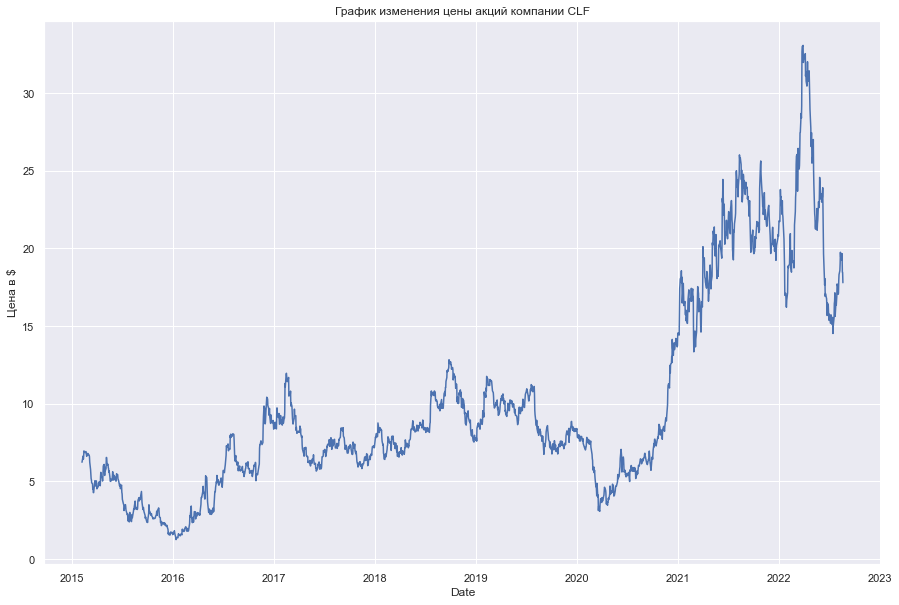

In [528]:
# Строим график изменения цены за весь период
ax = sns.lineplot(x = 'Date', y = 'Close', data = stocks_df)
plt.title('График изменения цены акций компании {}'.format(stock))
plt.ylabel('Цена в $')


In [484]:
# Функции расчетов скользящих средних
# Simple Moving Average
def SMA(data, ndays): 
     SMA = pd.Series(data['Close'].rolling(ndays).mean().round(4), name = 'SMA' + str(ndays))  
     return SMA

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
     EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean().round(4), 
                 name = 'EWMA_' + str(ndays))
     return EMA

In [485]:
# Считаем динамику изменения цены акции по дням и изменение в процентном соотношении
stocks_df['range'] = stocks_df.High - stocks_df.Low
stocks_df['score'] = ((stocks_df.Close - stocks_df.Open)/stocks_df.Open).mul(100).round(2)

In [486]:
# Рассчитываем простые и экспоненциальные скользящие средние
# Calculate simple and exponential moving average
stocks_df['sma10'] = SMA(stocks_df, 10)
stocks_df['ema10'] = EWMA(stocks_df,10)
stocks_df['ema12'] = EWMA(stocks_df,12)
stocks_df['ema26'] = EWMA(stocks_df,26)

In [487]:
# В стратегии MACD мы используем две линии: линия MACD - Схождение/расхождение скользящих средних,
# которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA, и сигнальную линию,
# которая является 9-дневной EMA линии MACD

# Calculate MACD
stocks_df['macd'] = stocks_df['ema12']- stocks_df['ema26'] 

# Calculate Signal
stocks_df['macdsignal'] = stocks_df.macd.ewm(span=9, adjust=False).mean()

In [488]:
# Создание торгового сигнала
# Define Signal, 1 значит сигнал к покупке, -1 сигнал к продаже
stocks_df['trading_signal_macd'] = np.where(stocks_df['macd'] > stocks_df['macdsignal'], 1, -1)

In [489]:
stocks_df

,Open,High,Low,Close,Volume,Currency,range,score,sma10,ema10,ema12,ema26,macd,macdsignal,trading_signal_macd
Date,,,,,,,,,,,,,,,
2015-01-02,7.31,7.33,6.81,6.99,7356031,USD,0.52,-4.38,NaN,NaN,NaN,NaN,NaN,NaN,-1
2015-01-05,6.71,6.79,6.27,6.48,9198703,USD,0.52,-3.43,NaN,NaN,NaN,NaN,NaN,NaN,-1
2015-01-06,6.52,6.60,6.20,6.27,6502924,USD,0.40,-3.83,NaN,NaN,NaN,NaN,NaN,NaN,-1
2015-01-07,6.40,6.93,6.32,6.80,7722775,USD,0.61,6.25,NaN,NaN,NaN,NaN,NaN,NaN,-1
2015-01-08,7.04,7.35,6.81,7.29,11109582,USD,0.54,3.55,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,19.25,19.30,18.85,19.23,8934175,USD,0.45,-0.10,18.612,18.7310,18.5434,17.8855,0.6579,0.335340,1
2022-08-16,19.53,19.82,19.28,19.66,8174812,USD,0.54,0.67,18.873,18.8999,18.7152,18.0170,0.6982,0.407912,1
2022-08-17,19.19,19.19,18.35,18.47,13375183,USD,0.84,-3.75,19.008,18.8218,18.6774,18.0505,0.6269,0.451710,1


In [490]:
stocks_df = stocks_df.dropna()

In [491]:
stocks_df

,Open,High,Low,Close,Volume,Currency,range,score,sma10,ema10,ema12,ema26,macd,macdsignal,trading_signal_macd
Date,,,,,,,,,,,,,,,
2015-02-06,6.35,6.48,6.11,6.23,10565819,USD,0.37,-1.89,6.555,6.6751,6.7551,7.0233,-0.2682,-0.268200,-1
2015-02-09,6.20,6.79,6.20,6.53,11494917,USD,0.59,5.32,6.490,6.6486,6.7200,6.9811,-0.2611,-0.266780,1
2015-02-10,6.48,6.74,6.39,6.63,6418902,USD,0.35,2.31,6.477,6.6452,6.7060,6.9513,-0.2453,-0.262484,1
2015-02-11,6.50,6.67,6.41,6.43,5344696,USD,0.26,-1.08,6.462,6.6059,6.6631,6.9077,-0.2446,-0.258907,1
2015-02-12,6.60,6.78,6.55,6.61,4705404,USD,0.23,0.15,6.516,6.6067,6.6549,6.8830,-0.2281,-0.252746,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,19.25,19.30,18.85,19.23,8934175,USD,0.45,-0.10,18.612,18.7310,18.5434,17.8855,0.6579,0.335340,1
2022-08-16,19.53,19.82,19.28,19.66,8174812,USD,0.54,0.67,18.873,18.8999,18.7152,18.0170,0.6982,0.407912,1
2022-08-17,19.19,19.19,18.35,18.47,13375183,USD,0.84,-3.75,19.008,18.8218,18.6774,18.0505,0.6269,0.451710,1


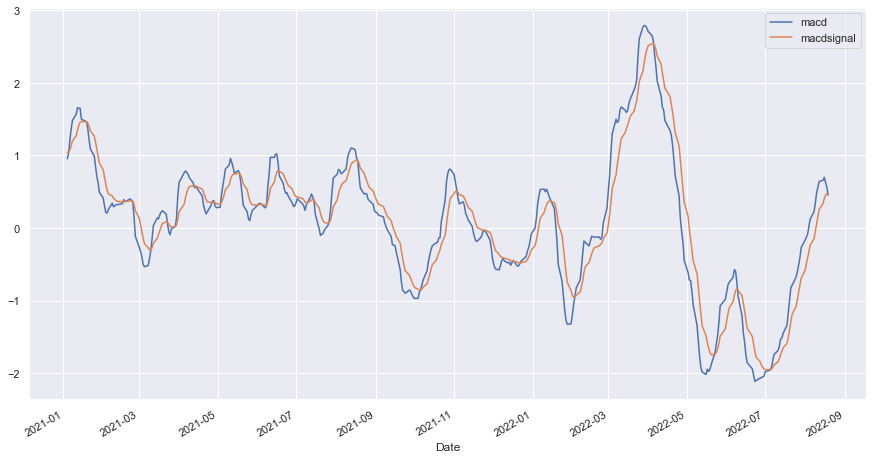

In [492]:
# строим график линии MACD, которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA,
# и сигнальную линию, которая является 9-дневной EMA линии MACD
# Когда линия MACD пересекает сигнальную линию снизу вверх, рекомендуется покупать базовую ценную бумагу.
# Когда линия MACD пересекает сигнальную линию сверху вниз, срабатывает сигнал на продажу.
stocks_df[stocks_df.index >= date_plot][['macd','macdsignal']].plot(figsize=(15,8))
plt.grid(True)
plt.show()

In [493]:
# Убираем индексацию по дате
stocks_df = stocks_df.reset_index()

In [494]:
# создаем серию с данными о торговых сигналах для анализа частоты пересечений графиков скользящих средних
trading_signal_macd_intervals = stocks_df[stocks_df.Date >= date_from] \
                            [['Date','trading_signal_macd']].set_index('Date')
trading_signal_macd_list = trading_signal_macd_intervals.trading_signal_macd.tolist()

In [495]:
# Считаем количество пересечений графиков скользящих средних, то есть интервалов

intervals = 1
k = 1

for i in trading_signal_macd_list:
    if k != len(trading_signal_macd_list):
        if i != trading_signal_macd_list[k]:
            intervals += 1
            k += 1
        else:
            k +=1
print('В заданном временном диапазоне с {} по {} графики MACD и MACD_signal пересекаются {} раз(а)' \
                        .format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today, intervals-1))

В заданном временном диапазоне с 01/01/2021 по 20/08/2022 графики MACD и MACD_signal пересекаются 144 раз(а)


In [496]:
# Оптимизация кода. замена конструкции if (в старой версии) на цикл While. Находим сколько дней прошло с момента последнего торгового сигнала
# и выведем на экран сведения о цене акции по состоянию на дату последнего торгового сигнала
index = -1
while trading_signal_macd_list[index - 1] == trading_signal_macd_list[index]:
    index -= 1
    
if trading_signal_macd_list[index + 1] == 1:
    signal = 'Buy'
else:
    signal = 'Sell'

last_signal_date = stocks_df.Date.iloc[len(stocks_df)-abs(index)].strftime('%d/%m/%Y')

print('The last trading signal was {} ({} trading sessions ago). Date {}'.format(signal, abs(index), last_signal_date))
print('------------------------------------------')
print(stocks_df.iloc[len(stocks_df)-abs(index)]) # выводим информацию по дате последнего актуального торгового сигнала

The last trading signal was Sell (1 trading sessions ago). Date 19/08/2022
------------------------------------------
Date                   2022-08-19 00:00:00
Open                                 18.02
High                                 18.13
Low                                  17.68
Close                                17.79
Volume                             8393265
Currency                               USD
range                                 0.45
score                                -1.28
sma10                               19.007
ema10                              18.5789
ema12                              18.5113
ema26                              18.0586
macd                                0.4527
macdsignal                        0.469618
trading_signal_macd                     -1
Name: 1897, dtype: object


In [497]:
trading_signal_macd_intervals = trading_signal_macd_intervals.reset_index()

In [498]:
# находим уникальные даты сигналов и выносим в отдельный датафрейм, а также считаем длительность каждого
# тренда между сигналами к покупке/продаже и найдем среднюю продолжительность тренда согласно индикатору MACD

signal_dates_list = []
trade_signal_list = []

intervals_list = []

sum_i = 1
k = 1
for i in trading_signal_macd_intervals.trading_signal_macd:
    if k != len(trading_signal_macd_intervals.trading_signal_macd):
        if i == trading_signal_macd_intervals.trading_signal_macd[k]:
            sum_i += 1
            k += 1
        else:
            intervals_list.append(sum_i)
            sum_i = 1
            k += 1
            signal_dates_list.append(trading_signal_macd_intervals.Date[k-1])
            trade_signal_list.append(trading_signal_macd_intervals.trading_signal_macd[k-1])
    else:
        intervals_list.append(sum_i)
print(intervals_list)

trading_action_df = pd.DataFrame()
trading_action_df['Date'] = signal_dates_list
#trading_action_df['Signal'] = trade_signal_list

print('---------------------------------')
print('Средняя продолжительность локального тренда согласно индикатору MACD составляет {} дней'.format( round(pd.Series(intervals_list).mean(),1) ))


[1, 18, 14, 33, 20, 5, 27, 33, 16, 11, 6, 12, 28, 10, 5, 25, 2, 11, 3, 3, 12, 11, 2, 4, 18, 18, 5, 15, 1, 6, 32, 12, 9, 8, 6, 25, 19, 6, 12, 12, 27, 6, 8, 6, 5, 16, 2, 36, 20, 11, 16, 4, 4, 8, 15, 45, 17, 17, 16, 35, 14, 1, 22, 15, 21, 19, 24, 1, 16, 6, 11, 36, 27, 11, 8, 15, 11, 24, 4, 7, 25, 2, 4, 13, 7, 28, 2, 22, 31, 11, 24, 35, 1, 22, 17, 10, 1, 1, 7, 20, 8, 1, 8, 22, 11, 22, 11, 8, 20, 1, 1, 3, 11, 8, 4, 10, 1, 1, 8, 2, 3, 11, 9, 3, 2, 7, 15, 3, 8, 16, 35, 20, 14, 1, 15, 1, 3, 16, 12, 43, 32, 13, 16, 32, 1]
---------------------------------
Средняя продолжительность локального тренда согласно индикатору MACD составляет 13.1 дней


In [499]:
# Оставляем в исходном датафрейме данные, содержащие информацию о днях, когда были сигналы к покупке/продаже
macd_analitics_df = trading_action_df.merge(stocks_df, on = 'Date')

In [500]:
# анализируем эффективности модели MACD, считаем доходность на одну акцию с учетом следования сратегии
# total_macd - сумма по колонке Close для всех торговых сигналов, если бы каждый раз мы продавали или покупали одну акцию
# чтобы посчитать эффективность модели, необходимо выбрать только закрытые сделки (количество покупок и продаж должно быть равным)

total_macd = macd_analitics_df[macd_analitics_df.trading_signal_macd == -1].Close.sum()- macd_analitics_df[macd_analitics_df.trading_signal_macd == 1].Close.sum()

if macd_analitics_df.trading_signal_macd.sum() > 0:
    total_macd = round(total_macd + macd_analitics_df.Close.tolist()[-1], 2)
    
elif macd_analitics_df.trading_signal_macd.sum() < 0:
    total_macd = round(total_macd - macd_analitics_df.Close.tolist()[0], 2)

print('Прибыль/убыток на каждую акцию {} от совершения всех предложенных сделок согласно индикатору MACD'.format(stock))
print('в период с {} по {} составил {} {}'.format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today, round(total_macd, 2), stocks_df.Currency[0] ))

print(trading_action_df.merge(stocks_df[['Date', 'trading_signal_macd', 'Close']], on = 'Date'))
print('-------------------------------')
print('total profit/loss per stock = {} {}'.format( round(total_macd, 2), stocks_df.Currency[0]))

Прибыль/убыток на каждую акцию CLF от совершения всех предложенных сделок согласно индикатору MACD
в период с 01/01/2021 по 20/08/2022 составил 17.72 USD
          Date  trading_signal_macd  Close
0   2015-02-09                    1   6.53
1   2015-03-06                   -1   6.23
2   2015-03-26                    1   4.76
3   2015-05-13                   -1   5.83
4   2015-06-11                    1   5.49
..         ...                  ...    ...
139 2022-04-06                   -1  31.09
140 2022-05-23                    1  23.01
141 2022-06-10                   -1  19.64
142 2022-07-06                    1  15.19
143 2022-08-19                   -1  17.79

[144 rows x 3 columns]
-------------------------------
total profit/loss per stock = 17.72 USD


In [501]:
# подготовим датайрейм для дальнейшего анализа (переименуем колонки для удобства)
trading_action_df = trading_action_df.merge(stocks_df[['Date', 'trading_signal_macd', 'Close']], on = 'Date').rename(columns={'trading_signal_macd':'signal','Close':'price'})

In [502]:
trading_action_df.head()

,Date,signal,price
0,2015-02-09,1,6.53
1,2015-03-06,-1,6.23
2,2015-03-26,1,4.76
3,2015-05-13,-1,5.83
4,2015-06-11,1,5.49


### Далее проанилизируем эффективность индикатора в разрезе отдельных сделок

In [503]:
# создадим серию с датами сигналов к покупке и продаже
# далее трансормируем датафрейм таким образом, чтобы в одной строке у нас были даты сигналов к покупке и продаже, а также цены

In [504]:
if trading_action_df.signal.iloc[0] == trading_action_df.signal.iloc[-1]:
    trading_action_df = trading_action_df.drop(trading_action_df.index[-1])

In [505]:
sell_date = trading_action_df[trading_action_df.signal == -1].rename(columns = {'Date': 'sell_date', 'price': 'sell_price'}).drop(['signal'], axis = 1)
buy_date = trading_action_df[trading_action_df.signal == 1].rename(columns = {'Date': 'buy_date', 'price': 'buy_price'}).drop(['signal'], axis = 1)

In [506]:
join_df = pd.concat([buy_date.reset_index(drop = True), sell_date.reset_index(drop = True)],axis=1)

In [507]:
# добавим колонки со значением финансового результата совершенных сделок
join_df['result'] = join_df['sell_price'] - join_df['buy_price']
join_df['percent'] = round((join_df['result'] / join_df['buy_price']).mul(100), 2)
join_df['profit'] = join_df['result'] > 0

In [508]:
join_df

,buy_date,buy_price,sell_date,sell_price,result,percent,profit
0,2015-02-09,6.53,2015-03-06,6.23,-0.30,-4.59,False
1,2015-03-26,4.76,2015-05-13,5.83,1.07,22.48,True
2,2015-06-11,5.49,2015-06-18,5.05,-0.44,-8.01,False
3,2015-07-28,2.95,2015-09-14,3.23,0.28,9.49,True
4,2015-10-06,3.49,2015-10-21,2.58,-0.91,-26.07,False
...,...,...,...,...,...,...,...
67,2021-12-17,20.59,2021-12-20,19.23,-1.36,-6.61,False
68,2021-12-23,20.29,2022-01-18,20.59,0.30,1.48,True
69,2022-02-03,18.75,2022-04-06,31.09,12.34,65.81,True
70,2022-05-23,23.01,2022-06-10,19.64,-3.37,-14.65,False


In [509]:
join_df.result.describe()

count    72.000000
mean      0.246111
std       1.993928
min      -3.370000
25%      -0.752500
50%      -0.145000
75%       0.950000
max      12.340000
Name: result, dtype: float64

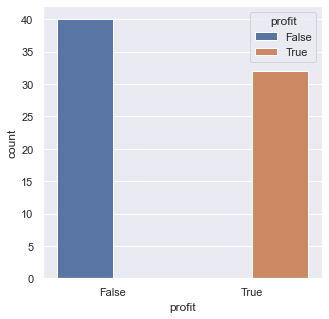

In [510]:
# посмотрим статистику прибыльных и убыточных сделок
fig = plt.figure(figsize=(5, 5))
ax = sns.countplot(x="profit", hue="profit", data=join_df)


Text(0.5, 8.95999999999998, 'Прибыль/убычток в %')

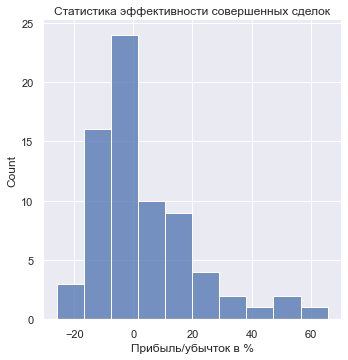

In [511]:
# посмотрим график распределения прибыльности/убыточности сделок

ax = sns.displot(join_df.percent)
plt.title('Статистика эффективности совершенных сделок')
plt.xlabel('Прибыль/убычток в %')

#### Проведем анализ динамики изменения капитала при условии алгоритмической торговли по данной стратегии

In [512]:
# Теперь визуализируем динамику изменения капитала
# при условии, что одна акция на момент начала торговли составляет 50% от стоимости капитала (50% оставим в качестве резерва)
# то есть начнем торговать на половину депозита и далее будем отслеживать прирост/снижение депозита.

In [513]:
start_deposit = df.Open[0] * 2 # стартовый капитал согласно условиям, при котором для покупки одной акции потребуется 50% депозита
deposit_history = [start_deposit] # создадим список с данными об изменении капитала после совершения каждой сделки

deposit = start_deposit
for result in join_df.result:
    deposit += result
    deposit_history.append(round(deposit, 2))

In [514]:
# добавим в таблицу колонку с данными о депозите по состоянию на даты совершения сделок
join_df['deposit'] = pd.Series(deposit_history[1:])

In [515]:
join_df

,buy_date,buy_price,sell_date,sell_price,result,percent,profit,deposit
0,2015-02-09,6.53,2015-03-06,6.23,-0.30,-4.59,False,14.32
1,2015-03-26,4.76,2015-05-13,5.83,1.07,22.48,True,15.39
2,2015-06-11,5.49,2015-06-18,5.05,-0.44,-8.01,False,14.95
3,2015-07-28,2.95,2015-09-14,3.23,0.28,9.49,True,15.23
4,2015-10-06,3.49,2015-10-21,2.58,-0.91,-26.07,False,14.32
...,...,...,...,...,...,...,...,...
67,2021-12-17,20.59,2021-12-20,19.23,-1.36,-6.61,False,20.47
68,2021-12-23,20.29,2022-01-18,20.59,0.30,1.48,True,20.77
69,2022-02-03,18.75,2022-04-06,31.09,12.34,65.81,True,33.11
70,2022-05-23,23.01,2022-06-10,19.64,-3.37,-14.65,False,29.74


Text(0, 0.5, 'Размер депозита в $')

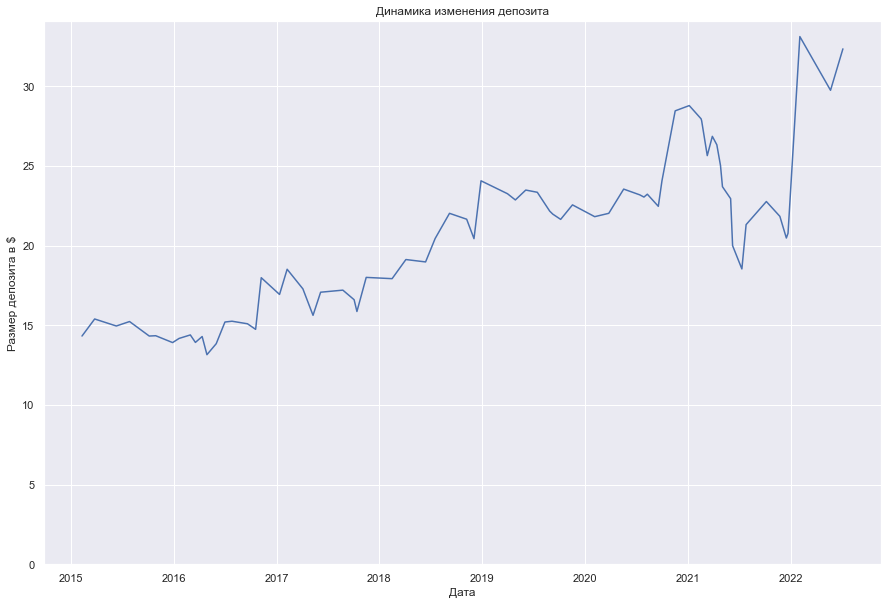

In [516]:
# посмотрим на графике динамику изменения капитала
ax = sns.lineplot(x = join_df.buy_date, y = join_df.deposit)
ax.set_title('Динамика изменения депозита')
ax.set_ylim(0)
ax.set_xlabel('Дата')
ax.set_ylabel('Размер депозита в $')


In [517]:
# подведем итоги: посчитаем статистику прибыльных и убыточных сделок
# финансовый результат или прирост капитала, выраженный в %, а также прибыльность/убыточность самой стратегии

finance_result = round(((total_macd + join_df.buy_price[0]) / join_df.buy_price[0]) *100 - 100 , 2)


print('Анализируемый период с {} по {}'.format(datetime.strptime(date_plot, '%m/%d/%Y').strftime('%d/%m/%Y'), today))
print('-----------------------------------')
print('Всего за указанный период было совершено {} сделок, из которых:'.format(len(join_df)) )
print('Прибыльных: {}, что составляет {} %'.format(len(join_df[join_df.profit == True]), round((len(join_df[join_df.profit == True]) / len(join_df)) * 100, 1)   ))
print('Убыточных: {}, что составляет {} %'.format(len(join_df[join_df.profit == False]), round((len(join_df[join_df.profit == False]) / len(join_df)) * 100, 1)   ))
print('-----------------------------------')
print('Максимальная прибыль одной сделки {} %'.format( round(join_df.percent.max(), 1)   ))
print('Максимальный убыток одной сделки {} %'.format( round(join_df.percent.min(), 1)   ))
print('-----------------------------------')
print('Общий финансовый результат на одну акцию составил:')
print('{} %'.format(finance_result))
print('Депозит изменился со значения {} до {} {}'.format(start_deposit, round(deposit, 2), stocks_df.Currency[0]) )

years = (datetime.now() - datetime.strptime(date_from, '%m/%d/%Y')).days / 365
print('Таким образом прирост капитала составил {} %'.format(round(deposit / start_deposit * 100 - 100, 2))   )
print('Прибыльность/убыточность стратегии за указанный период {} % годовых'.format( round((deposit / start_deposit * 100 - 100) / years, 2 )) )

Анализируемый период с 01/01/2021 по 20/08/2022
-----------------------------------
Всего за указанный период было совершено 72 сделок, из которых:
Прибыльных: 32, что составляет 44.4 %
Убыточных: 40, что составляет 55.6 %
-----------------------------------
Максимальная прибыль одной сделки 65.8 %
Максимальный убыток одной сделки -26.1 %
-----------------------------------
Общий финансовый результат на одну акцию составил:
271.36 %
Депозит изменился со значения 14.62 до 32.34 USD
Таким образом прирост капитала составил 121.2 %
Прибыльность/убыточность стратегии за указанный период 15.87 % годовых
